# Wolf-Sheep Predation Model

For this exercise we refer to the original implementation from Wilensky (1997) in `Mesa`. As reference, we used the code from `Mesa`'s example for this case study: https://github.com/projectmesa/mesa/tree/main/examples/wolf_sheep

Before you start, we reccomend you to go ahead and do the basic `Mesa` tutorial from:
https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html

We will visit this tutorial in class.


## Summary

A simple ecological model, consisting of three agent types: wolves, sheep, and grass. The wolves and the sheep wander around the grid at random. Wolves and sheep both expend energy moving around, and replenish it by eating. Sheep eat grass, and wolves eat sheep if they end up on the same grid cell.

If wolves and sheep have enough energy, they reproduce, creating a new wolf or sheep (in this simplified model, only one parent is needed for reproduction). The grass on each cell regrows at a constant rate. If any wolves and sheep run out of energy, they die. 


In [46]:
import mesa
import numpy as np
import plotly as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt

Both sheeps and wolf roam around in random fashion. Let's first create an instance of an `Mesa` agent class that we'll call `RandomWalker`. Both sheeps and wolfs will be random walkers

In [47]:
"""
Generalized behavior for random walking, one grid cell at a time.
"""

class RandomWalker(mesa.Agent):
    """
    Class implementing random walker methods in a generalized manner.
    Not intended to be used on its own, but to inherit its methods to multiple
    other agents.
    """

    grid = None
    x = None
    y = None
    moore = True

    def __init__(self, unique_id, pos, model, moore=True):
        """
        grid: The MultiGrid object in which the agent lives.
        x: The agent's current x coordinate
        y: The agent's current y coordinate
        moore: If True, may move in all 8 directions.
                Otherwise, only up, down, left, right.
        """
        super().__init__(unique_id, model)
        self.pos = pos
        self.moore = moore

    def random_move(self):
        """
        Step one cell in any allowable direction.
        """
        # Pick the next cell from the adjacent cells.
        next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
        next_move = self.random.choice(next_moves)
        # Now move:
        self.model.grid.move_agent(self, next_move)

Now, lets define our two agents, `Sheep` and `Wolf` as `RandomWalker` agents

In [48]:
class Sheep(RandomWalker):
    """
    A sheep that walks around, reproduces (asexually) and gets eaten.
    The init is the same as the RandomWalker.
    """

    energy = None

    def __init__(self, unique_id, pos, model, moore, min_reproduce_energy, energy=None):
        super().__init__(unique_id, pos, model, moore=moore)
        self.energy = energy
        self.min_reproduce_energy = min_reproduce_energy

    def step(self):
        """
        A model step. Move, then eat grass and reproduce.
        """
        self.random_move()
        living = True

        # If grass is initialized in model
        if self.model.grass:
            # Reduce energy
            self.energy -= 1

            # If there is grass available, eat it
            this_cell = self.model.grid.get_cell_list_contents([self.pos])
            grass_patch = [obj for obj in this_cell if isinstance(obj, GrassPatch)][0]
            if grass_patch.fully_grown:
                self.energy += self.model.sheep_gain_from_food
                grass_patch.fully_grown = False

            # Death
            if self.energy < 0:
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
                living = False

        if living and self.random.random() < self.model.sheep_reproduce and self.energy >= self.min_reproduce_energy:
            # Create a new sheep:
            if self.model.grass:
                self.energy /= 2
            lamb = Sheep(
                self.model.next_id(), self.pos, self.model, self.moore, self.min_reproduce_energy, self.energy
            )
            self.model.grid.place_agent(lamb, self.pos)
            self.model.schedule.add(lamb)

In [49]:
class Wolf(RandomWalker):
    """
    A wolf that walks around, reproduces (asexually) and eats sheep.
    """

    energy = None

    def __init__(self, unique_id, pos, model, moore, min_reproduce_energy, energy=None):
        super().__init__(unique_id, pos, model, moore=moore)
        self.energy = energy
        self.min_reproduce_energy = min_reproduce_energy

    def step(self):
        self.random_move()
        self.energy -= 1

        # If there are sheep present, eat one
        x, y = self.pos
        this_cell = self.model.grid.get_cell_list_contents([self.pos])
        sheep = [obj for obj in this_cell if isinstance(obj, Sheep)]
        if len(sheep) > 0:
            sheep_to_eat = self.random.choice(sheep)
            self.energy += self.model.wolf_gain_from_food

            # Kill the sheep
            self.model.grid.remove_agent(sheep_to_eat)
            self.model.schedule.remove(sheep_to_eat)

        # Death or reproduction
        if self.energy < 0:
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
        else:
            if self.random.random() < self.model.wolf_reproduce and self.energy >= self.min_reproduce_energy:
                # Create a new wolf cub
                self.energy /= 2
                cub = Wolf(
                    self.model.next_id(), self.pos, self.model, self.moore, self.min_reproduce_energy, self.energy
                )
                self.model.grid.place_agent(cub, cub.pos)
                self.model.schedule.add(cub)

And the grass, `GrassPatch`, as a regular (not random walker) agent...

In [50]:
class GrassPatch(mesa.Agent):
    """
    A patch of grass that grows at a fixed rate and it is eaten by sheep
    """

    def __init__(self, unique_id, pos, model, fully_grown, countdown):
        """
        Creates a new patch of grass
        Args:
            grown: (boolean) Whether the patch of grass is fully grown or not
            countdown: Time for the patch of grass to be fully grown again
        """
        super().__init__(unique_id, model)
        self.fully_grown = fully_grown
        self.countdown = countdown
        self.pos = pos

    def step(self):
        if not self.fully_grown:
            if self.countdown <= 0:
                # Set as fully grown
                self.fully_grown = True
                self.countdown = self.model.grass_regrowth_time
            else:
                self.countdown -= 1

Now let's create our `Mesa` model. Initiate the parameters of interest (self explanatory), create all agents, define the `step` function and the `run_model`

In [51]:
class WolfSheep(mesa.Model):
    """
    Wolf-Sheep Predation Model
    """

    height = 20
    width = 20

    initial_sheep = 100
    initial_wolves = 50

    sheep_reproduce = 0.04
    wolf_reproduce = 0.05
    min_reproduce_energy = 16

    sheep_gain_from_food = 4
    wolf_gain_from_food = 20

    grass = False
    grass_regrowth_time = 30

    # Print-monitoring
    verbose = True  
    # verbose = False

    description = (
        "A model for simulating wolf and sheep (predator-prey) ecosystem modelling."
    )

    def __init__(
        self,
        log,
        log_num,
        log_folder,
        verbose,
        width=20,
        height=20,
        initial_sheep=100,
        initial_wolves=50,
        sheep_reproduce=0.04,
        wolf_reproduce=0.05,
        min_reproduce_energy=16,
        wolf_gain_from_food=20,
        grass=False,
        grass_regrowth_time=30,
        sheep_gain_from_food=4,
    ):
        """
        Create a new Wolf-Sheep model with the given parameters.
        Args:
            initial_sheep: Number of sheep to start with
            initial_wolves: Number of wolves to start with
            sheep_reproduce: Probability of each sheep reproducing each step
            wolf_reproduce: Probability of each wolf reproducing each step
            min_reproduce_energy: Minimum energy (inclusive) required to reproduce
            wolf_gain_from_food: Energy a wolf gains from eating a sheep
            grass: Whether to have the sheep eat grass for energy
            grass_regrowth_time: How long it takes for a grass patch to regrow
                                 once it is eaten
            sheep_gain_from_food: Energy sheep gain from grass, if enabled.
        """
        super().__init__()
        # Set parameters
        self.width = width
        self.height = height
        self.initial_sheep = initial_sheep
        self.initial_wolves = initial_wolves
        self.sheep_reproduce = sheep_reproduce
        self.wolf_reproduce = wolf_reproduce
        self.min_reproduce_energy = min_reproduce_energy
        self.wolf_gain_from_food = wolf_gain_from_food
        self.grass = grass
        self.grass_regrowth_time = grass_regrowth_time
        self.sheep_gain_from_food = sheep_gain_from_food
        
        self.grass_count = 0
        self.wolves_evolution = []
        self.sheep_evolution = []
        self.grass_evolution = []

        self.verbose = verbose

        # For logging
        self.log = log
        if self.log:
            self.log_num = log_num
            self.log_folder = log_folder
            self.logfile_name = f"si{self.initial_sheep}_wi{self.initial_wolves}_sr{self.sheep_reproduce}_rt{self.min_reproduce_energy}_log{log_num}.txt"
            self.new_log = True

        self.schedule = RandomActivationByTypeFiltered(self)
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=True)
        self.datacollector = mesa.DataCollector(
            {
                "Wolves": lambda m: m.schedule.get_type_count(Wolf),
                "Sheep": lambda m: m.schedule.get_type_count(Sheep),
                "Grass": lambda m: m.schedule.get_type_count(GrassPatch, lambda x: x.fully_grown),
            }
        )

        # Create sheep:
        for i in range(self.initial_sheep):
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            energy = self.random.randrange(2 * self.sheep_gain_from_food)
            sheep = Sheep(self.next_id(), (x, y), self, True, self.min_reproduce_energy, energy)
            self.grid.place_agent(sheep, (x, y))
            self.schedule.add(sheep)

        # Create wolves
        for i in range(self.initial_wolves):
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            energy = self.random.randrange(2 * self.wolf_gain_from_food)
            wolf = Wolf(self.next_id(), (x, y), self, True, self.min_reproduce_energy, energy)
            self.grid.place_agent(wolf, (x, y))
            self.schedule.add(wolf)

        # Create grass patches
        if self.grass:
            for agent, x, y in self.grid.coord_iter():

                fully_grown = self.random.choice([True, False])

                if fully_grown:
                    countdown = self.grass_regrowth_time
                else:
                    countdown = self.random.randrange(self.grass_regrowth_time)

                patch = GrassPatch(self.next_id(), (x, y), self, fully_grown, countdown)
                self.grid.place_agent(patch, (x, y))
                self.schedule.add(patch)

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        if self.verbose:
            print(
                [
                    self.schedule.time,
                    self.schedule.get_type_count(Wolf),
                    self.schedule.get_type_count(Sheep),
                    self.schedule.get_type_count(GrassPatch, lambda x: x.fully_grown),
                    #self.grass_count,
                ]
            )
        if self.log:
            if self.new_log:
                mode = "w"
            else:
                mode = "a"

            with open(f"{self.log_folder}/{self.logfile_name}",mode) as f:
                f.write(f"{self.schedule.time},")
                f.write(f"{self.schedule.get_type_count(Wolf)},")
                f.write(f"{self.schedule.get_type_count(Sheep)},")
                f.write(f"{self.schedule.get_type_count(GrassPatch, lambda x: x.fully_grown)},\n")
                self.new_log = False

    def run_model(self, step_count=100):

        if self.verbose:
            print("Initial number wolves: ", self.schedule.get_type_count(Wolf))
            print("Initial number sheep: ", self.schedule.get_type_count(Sheep))
            print(
                "Initial number grass: ",
                self.schedule.get_type_count(GrassPatch, lambda x: x.fully_grown),
                #self.grass_count,
            )

        # Append time step 0 values
        self.wolves_evolution.append(self.schedule.get_type_count(Wolf))
        self.sheep_evolution.append(self.schedule.get_type_count(Sheep))
        self.initial_grass = self.schedule.get_type_count(GrassPatch, lambda x: x.fully_grown)
        self.grass_evolution.append(self.initial_grass)

        for i in range(step_count):
            self.step()
            self.wolves_evolution.append(self.schedule.get_type_count(Wolf))
            self.sheep_evolution.append(self.schedule.get_type_count(Sheep))
            self.grass_evolution.append(self.schedule.get_type_count(GrassPatch, lambda x: x.fully_grown))
           
        if self.verbose:
            print("")
            print("Final number wolves: ", self.schedule.get_type_count(Wolf))
            print("Final number sheep: ", self.schedule.get_type_count(Sheep))
            print(
                "Final number grass: ",
                self.schedule.get_type_count(GrassPatch, lambda x: x.fully_grown),
                #self.grass_count,
            )
        
        # initial_sheep: Number of sheep to start with
        # initial_wolves: Number of wolves to start with
        # sheep_reproduce: Probability of each sheep reproducing each step
        # wolf_reproduce: Probability of each wolf reproducing each step
        # min_reproduce_energy: Minimum energy (inclusive) required to reproduce
        # wolf_gain_from_food: Energy a wolf gains from eating a sheep
        # sheep_gain_from_food: Energy sheep gain from grass, if enabled.
        # grass: Whether to have the sheep eat grass for energy
        # grass_regrowth_time: How long it takes for a grass patch to regrow once it is eaten

        params = {"initial_sheep":self.initial_sheep,
                  "initial_wolves":self.initial_wolves,
                  "initial_grass":self.initial_grass,
                  "sheep_reproduce_prob":self.sheep_reproduce,
                  "wolf_reproduce_prob":self.wolf_reproduce,
                  "min_reproduce_energy":self.min_reproduce_energy,
                  "wolf_gain_from_food":self.wolf_gain_from_food,
                  "sheep_gain_from_food":self.sheep_gain_from_food,
                  "grass":self.grass,
                  "grass_regrowth_time":self.grass_regrowth_time}
        return params, self.log_folder, self.logfile_name[:-4]

Small extension to `Mesa`: Since we want are interest in computing the fully grown grass, we need a scheduler that has a `get_type_count` method to allow for filtering of agents by a function before counting.

In [52]:
from typing import Type, Callable

class RandomActivationByTypeFiltered(mesa.time.RandomActivationByType):
    """
    A scheduler that overrides the get_type_count method to allow for filtering
    of agents by a function before counting.
    Example:
    >>> scheduler = RandomActivationByTypeFiltered(model)
    >>> scheduler.get_type_count(AgentA, lambda agent: agent.some_attribute > 10)
    """

    def get_type_count(
        self,
        type_class: Type[mesa.Agent],
        filter_func: Callable[[mesa.Agent], bool] = None,
    ) -> int:
        """
        Returns the current number of agents of certain type in the queue that satisfy the filter function.
        """
        count = 0
        for agent in self.agents_by_type[type_class].values():
            if filter_func is None or filter_func(agent):
                count += 1
        return count

In [53]:
def plotter(model,model_params,log_folder,logfile_name,save_plot=True,show_plot=False):

    # use_scatter = True
    use_scatter = False

    fig,ax = plt.subplots(figsize=(20,12))
    plt.rcParams['savefig.facecolor'] = "0.8"
    steps = [i for i in range(1,101)]

    if use_scatter:
        ax.scatter(x=steps,
                y=model.sheep_evolution,
                label="Sheeps")
        ax.scatter(x=steps,
                y=model.wolves_evolution,
                label="Wolves")
        ax.scatter(x=steps,
                y=model.grass_evolution,
                label="Grass")
    else:
        ax.plot(model.sheep_evolution,label="Sheep Population")
        ax.plot(model.wolves_evolution,label="Wolves Population")
        ax.plot(model.grass_evolution,label="Grass Population")

    ax.set_title(f"\ninital_sheep={model_params['initial_sheep']}, initial_wolves={model_params['initial_wolves']}, initial_grass={model_params['initial_grass']}, sheep_reproduce_prob={model_params['sheep_reproduce_prob']}, reproduce_threshold={model_params['min_reproduce_energy']}\n",size=22)
    ax.set_xlabel(f"Time step",size=16)
    ax.set_xlim((0,100))
    ax.set_ylabel(f"Population",size=16)
    ax.legend(loc="center right",prop=dict(size=18))
    plt.tight_layout()
    ax.grid(which="both",linestyle='-')
    if save_plot:
        plt.savefig(f"{log_folder}/{logfile_name}.png")
    if show_plot:
        plt.show()
    else:
        plt.close()

FOR LOOPING

sheep_gain_from_food = 20
wolf_gain_from_food = 20
x = 0.04
verbose = False
log = True
log_folder = 'wolf_sheep_log'
sheep_gain_from_food = 20
wolf_gain_from_food = 20
x = 0.08
verbose = False
log = True
log_folder = 'wolf_sheep_log'
sheep_gain_from_food = 20
wolf_gain_from_food = 20
x = 0.16
verbose = False
log = True
log_folder = 'wolf_sheep_log'
sheep_gain_from_food = 20
wolf_gain_from_food = 20
x = 0.32
verbose = False
log = True
log_folder = 'wolf_sheep_log'
sheep_gain_from_food = 20
wolf_gain_from_food = 20
x = 0.64
verbose = False
log = True
log_folder = 'wolf_sheep_log'


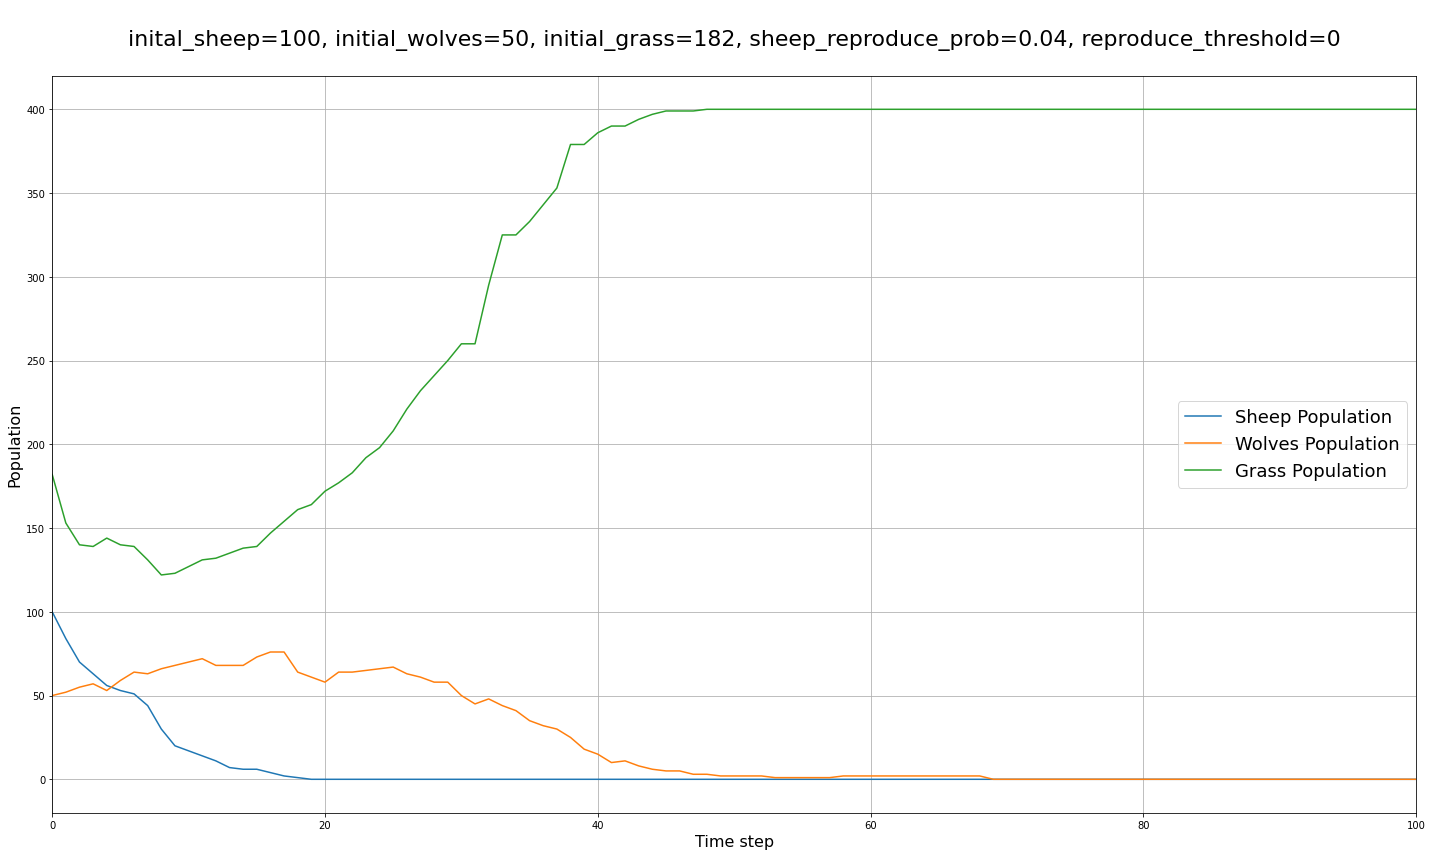

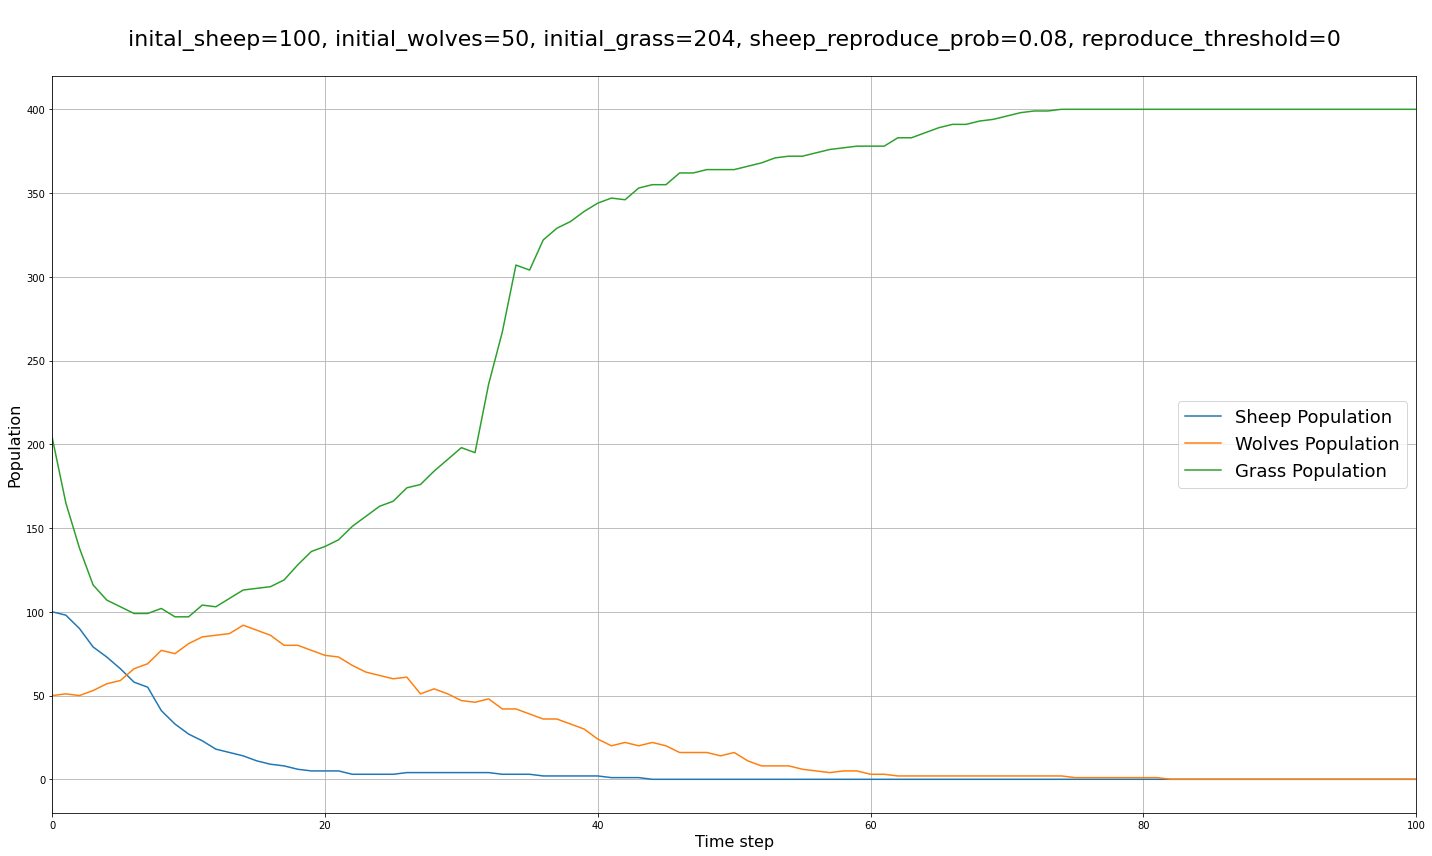

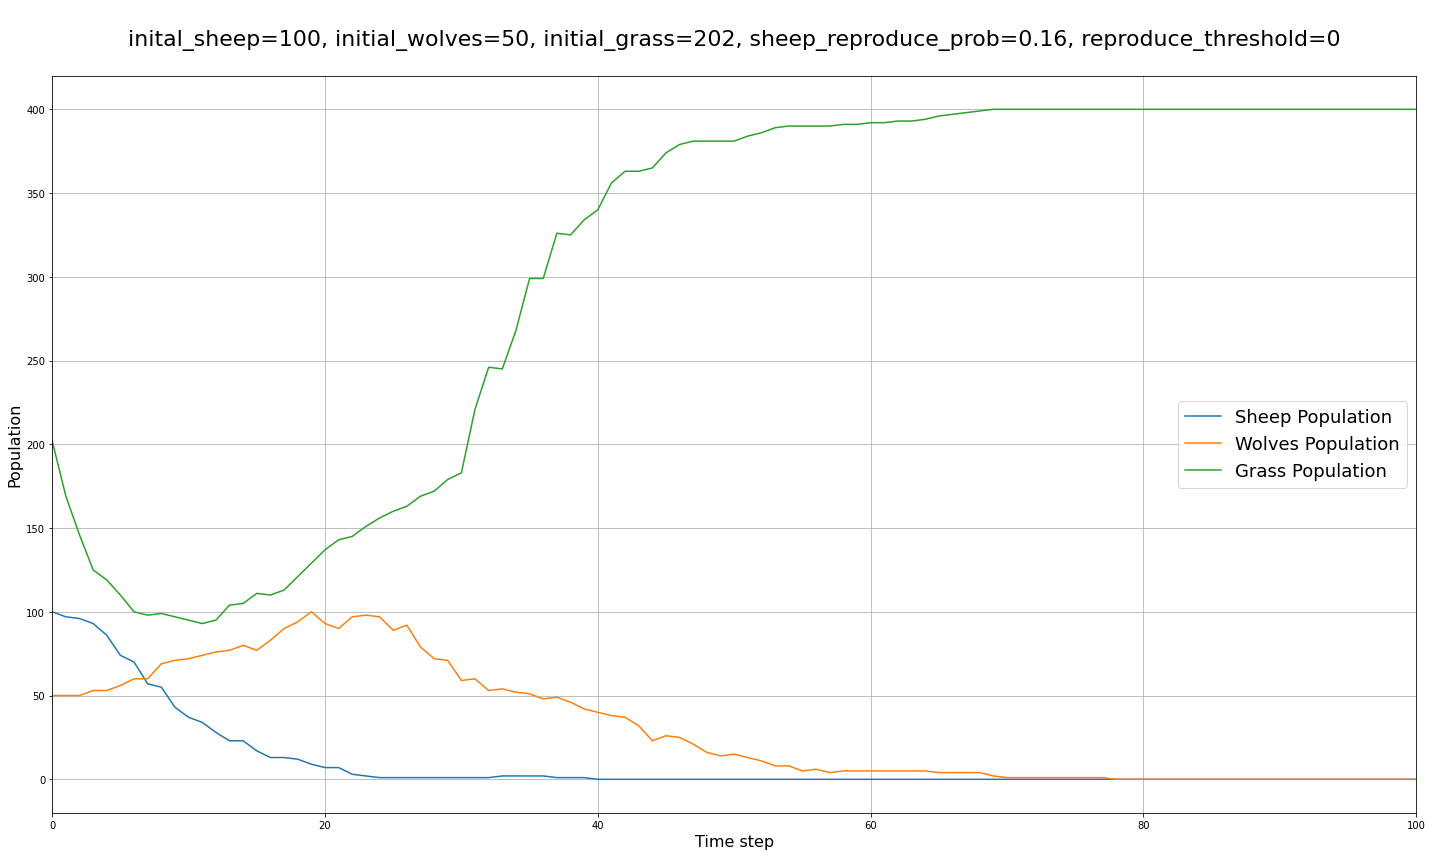

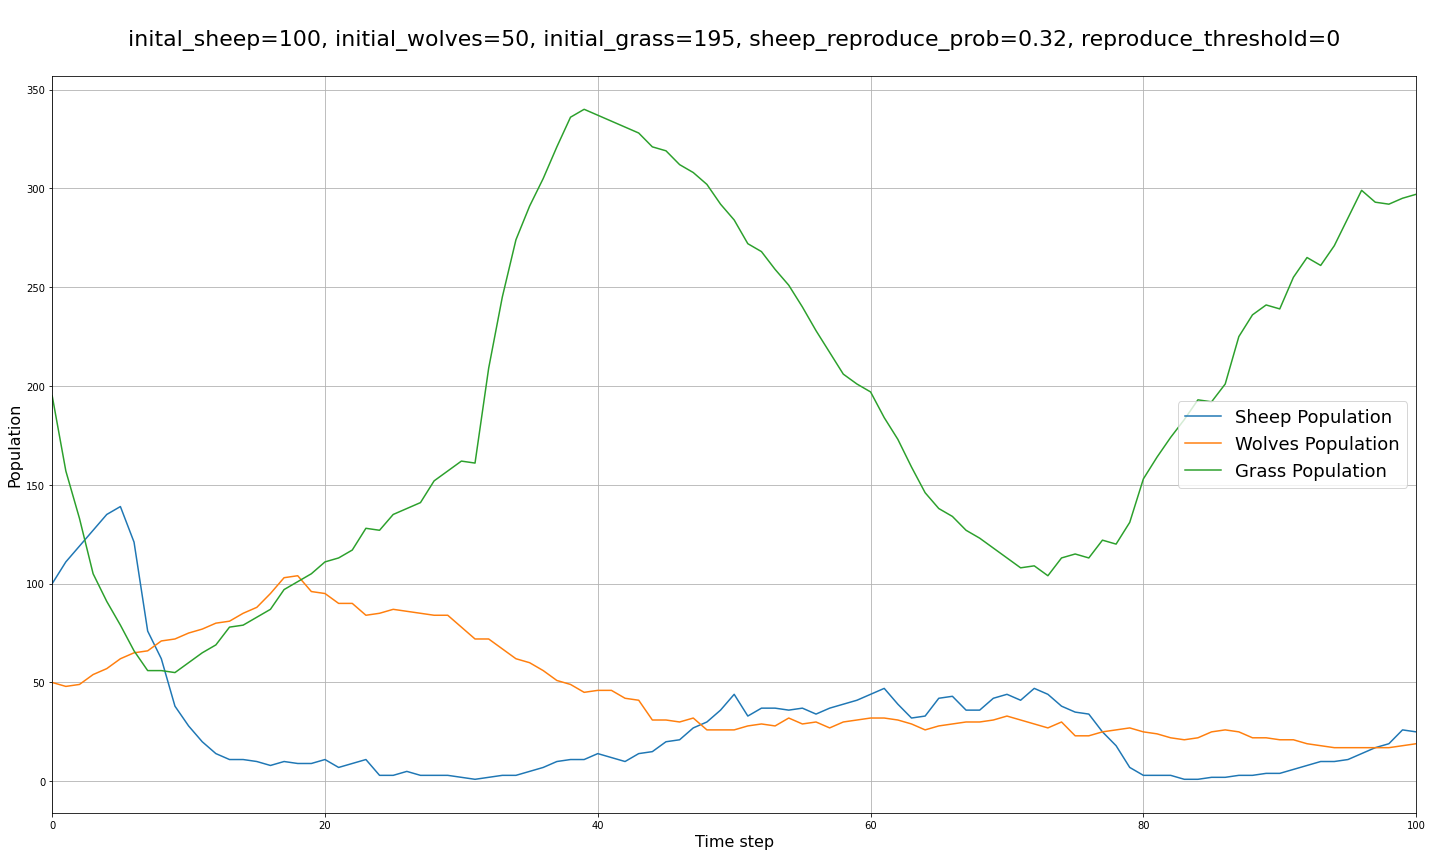

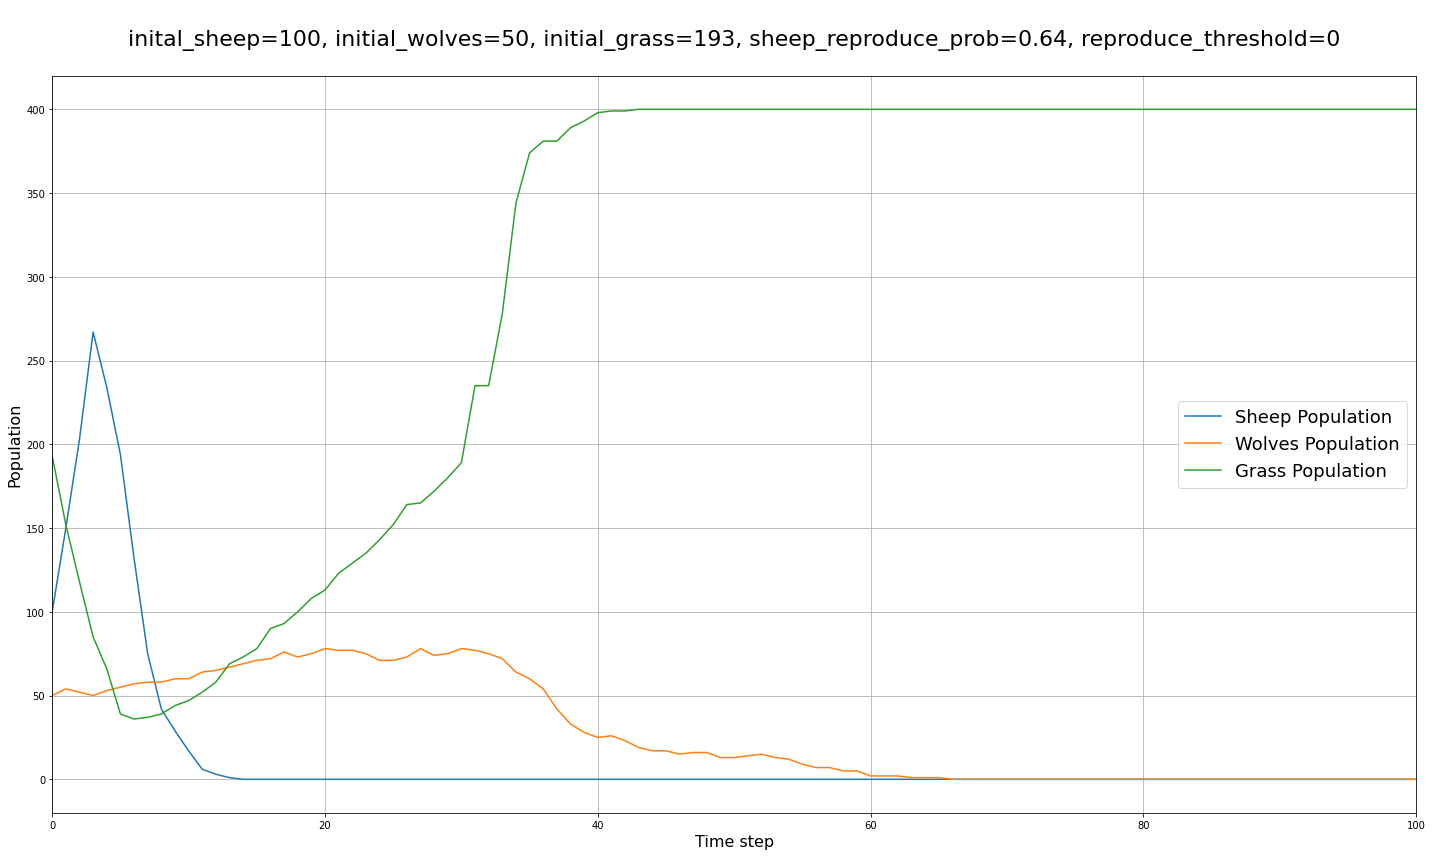

In [40]:
# How many times to run model using same parameters
num_same_scenario = 1

"""sheep_gain_from_food"""
# sheep_gain_from_food = 4
sheep_gain_from_food = 20

"""wolf_gain_from_food"""
# wolf_gain_from_food = 4
wolf_gain_from_food = 20

"""min_reproduce_energy"""
min_reproduce_energy = 0
# min_reproduce_energy = 5
# min_reproduce_energy = 10
# min_reproduce_energy = 16
# min_reproduce_energy = 50
# min_reproduce_energy = 100

"""sheep_reproduce_probability"""
# sheep_reproduce_probability = 0.04
# sheep_reproduce_probability = 0.08
# sheep_reproduce_probability = 0.16
# sheep_reproduce_probability = 0.32
# sheep_reproduce_probability = 0.64

# verbose = True
verbose = False

log = True
# log_num = 1
log_folder = "wolf_sheep_log"

"""lists"""
min_reproduce_energies = [0,5,10,15,16,20,50]
sheep_reproduce_probabilities = [0.04,0.08,0.16,0.32,0.64]

"""SET THIS"""
# this_list = min_reproduce_energies
this_list = sheep_reproduce_probabilities

for x in this_list:

    print(f"{sheep_gain_from_food = }")
    print(f"{wolf_gain_from_food = }")
    print(f"{x = }")
    print(f"{verbose = }")
    print(f"{log = }")
    print(f"{log_folder = }")

    for i in range(num_same_scenario):
        
        """Ensure only ONE model defined"""
        # min_reproduce_energy
        # model = WolfSheep(log=log,log_num=i+1,log_folder=log_folder,verbose=verbose,min_reproduce_energy=x,grass=True)

        # sheep_reproduce_probabilities
        model = WolfSheep(log=log,log_num=i+1,log_folder=log_folder,verbose=verbose,min_reproduce_energy=min_reproduce_energy,sheep_reproduce=x,grass=True)

        params, log_folder, logfile_name = model.run_model()
        plotter(model=model,model_params=params,log_folder=log_folder,logfile_name=logfile_name,show_plot=False)

FOR SINGLE RUN

initial_sheep = 120
sheep_gain_from_food = 4
wolf_gain_from_food = 4
wolf_reproduce = 0.03
min_reproduce_energy = 16
verbose = False
log = True
log_num = 1
log_folder = 'wolf_sheep_log'


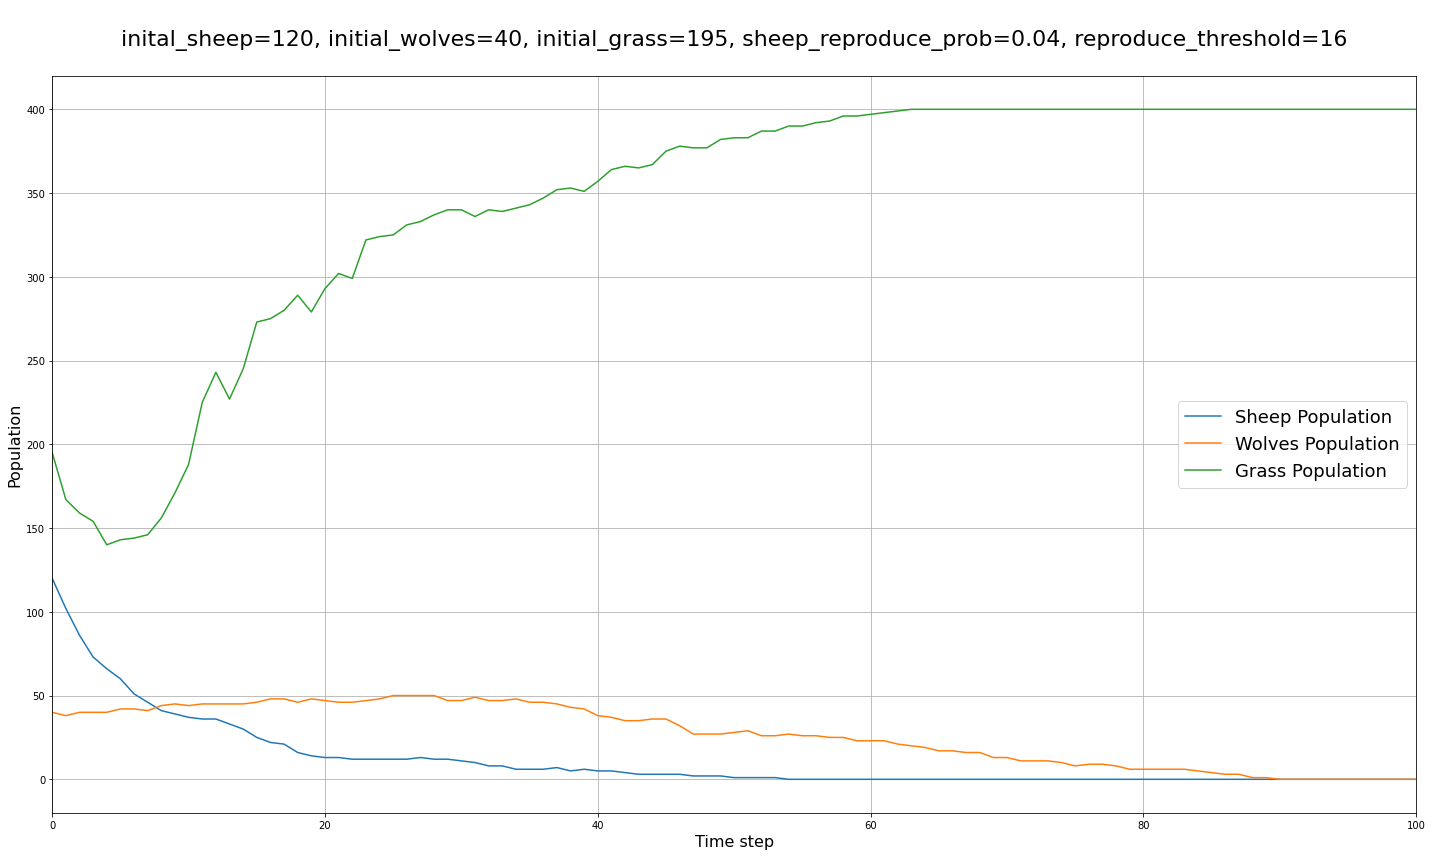

In [54]:
initial_sheep = 120

initial_wolves = 40

sheep_gain_from_food = 4
# sheep_gain_from_food = 20

wolf_gain_from_food = 4
# wolf_gain_from_food = 20

# wolf_reproduce = 0.01
wolf_reproduce = 0.03
# wolf_reproduce = 0.05
# wolf_reproduce = 0.10
# wolf_reproduce = 0.50

# min_reproduce_energy = 5
# min_reproduce_energy = 10
min_reproduce_energy = 16
# min_reproduce_energy = 50
# min_reproduce_energy = 100

grass_regrowth_time = 10
# grass_regrowth_time = 30

# verbose = True
verbose = False

log = True
log_num = 1
log_folder = "wolf_sheep_log"

print(f"{initial_sheep = }")
print(f"{sheep_gain_from_food = }")
print(f"{wolf_gain_from_food = }")
print(f"{wolf_reproduce = }")
print(f"{min_reproduce_energy = }")
print(f"{verbose = }")
print(f"{log = }")
print(f"{log_num = }")
print(f"{log_folder = }")

model = WolfSheep(log=log,log_num=log_num,log_folder=log_folder,verbose=verbose,initial_sheep=initial_sheep,initial_wolves=initial_wolves,wolf_reproduce=wolf_reproduce,min_reproduce_energy=min_reproduce_energy,grass_regrowth_time=grass_regrowth_time,grass=True)

params, log_folder, logfile_name = model.run_model()
# print(params)
# print(log_folder)
# print(logfile_name)
plotter(model=model,model_params=params,log_folder=log_folder,logfile_name=logfile_name,save_plot=False,show_plot=True)

And let's run it.

In [29]:
params, log_folder, logfile_name = model.run_model()
# print(params)
# print(log_folder)
# print(logfile_name)
plotter(model=model,model_params=params,log_folder=log_folder,logfile_name=logfile_name)

In [ ]:
# show_fig = True
show_fig = False

steps = [i for i in range(1, 100)]

fig = go.Figure([
    
    go.Scatter(
        name='Sheeps',
        x=steps,
        y=model.sheep_evolution,
        mode='lines',
        line=dict(width=1),
        showlegend=True
    ),
    go.Scatter(
        name='Wolves',
        x=steps,
        y=model.wolves_evolution,
        mode='lines',
        line=dict(width=1),
        showlegend=True
    ),
    go.Scatter(
        name='Grass',
        x=steps,
        y=model.grass_evolution,
        marker=dict(color="#444"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    )
])

# Install this version of kaleido --> `pip install kaleido==0.1.0post1`
# Quality sucks though
# fig.write_image(f"{log_folder}/{logfile_name}.png")

if show_fig:
    fig.show()

### Creation of a txt file for easy reading

In [ ]:
def txtfileoutput(file):
    global filecounter
    filename = 'model_'+str(filecounter) +".txt"
    f= open(filename,"w+")
    f.write(str(output))
    filecounter = filecounter + 1

### Converting of file into a textfile

In [331]:
print(output)

[50, 100, 192, 54, 79, 157, 53, 64, 142, 54, 57, 143, 57, 45, 142, 58, 42, 143, 62, 44, 137, 64, 40, 139, 66, 27, 138, 68, 25, 145, 69, 23, 145, 71, 20, 150, 69, 16, 158, 68, 13, 158, 68, 14, 157, 72, 12, 160, 66, 11, 164, 67, 11, 170, 68, 7, 176, 70, 6, 180, 71, 3, 180, 70, 3, 183, 71, 4, 189, 72, 4, 195, 72, 4, 202, 69, 4, 203, 66, 4, 206, 64, 4, 211, 63, 4, 212, 65, 3, 214, 61, 4, 217, 56, 4, 216, 55, 5, 258, 51, 4, 279, 52, 3, 299, 44, 3, 299, 45, 3, 306, 39, 2, 315, 38, 2, 330, 31, 3, 329, 30, 3, 335, 28, 3, 336, 27, 3, 338, 27, 3, 341, 27, 3, 338, 19, 2, 341, 16, 2, 347, 14, 2, 346, 11, 2, 345, 12, 3, 350, 9, 3, 348, 7, 3, 350, 7, 3, 348, 7, 3, 347, 7, 4, 350, 6, 4, 347, 5, 5, 348, 5, 5, 346, 6, 5, 343, 6, 5, 342, 6, 4, 344, 6, 3, 343, 2, 3, 343, 1, 4, 343, 1, 4, 342, 1, 4, 341, 1, 4, 339, 1, 4, 338, 1, 4, 338, 1, 4, 337, 1, 4, 338, 1, 4, 338, 1, 5, 338, 1, 5, 342, 1, 5, 341, 1, 5, 343, 1, 5, 345, 1, 5, 342, 1, 5, 341, 1, 5, 339, 1, 5, 337, 1, 5, 334, 1, 5, 336, 2, 7, 336, 2, 7, 

In [332]:
txtfileoutput(output)

## Reimporting into a dataframe

In [333]:
import pandas as pd
data = pd.read_csv('model_1.txt', sep=" ", header=None)

In [334]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,300,301,302
0,"[50,","100,","205,","47,","84,","162,","48,","78,","144,","50,",...,"359,","0,","3,","358,","0,","3,","360,","0,","3,",358]


In [335]:
a =data.values[0][0].replace(',', '').replace('[', '').replace(']', '')
print(float(a))

50.0


In [336]:
def txttodataframe(dataframe):
    sheeplist = []
    wolveslist = []
    grasslist = []
    totalnumber = len(dataframe.columns) // 3
    for i in range(totalnumber):
        sheep = dataframe.values[0][3*i].replace(',', '').replace('[', '').replace(']', '')
        wolves = dataframe.values[0][3*i + 1].replace(',', '').replace('[', '').replace(']', '')
        grass = dataframe.values[0][3*i + 2].replace(',', '').replace('[', '').replace(']', '')
        sheeplist.append(float(sheep))
        wolveslist.append(float(wolves))
        grasslist.append(float(grass))
    print("converted file")
    return sheeplist, wolveslist, grasslist
        

In [364]:
import matplotlib.pyplot as plt
def plotter(data):
    filename = "model_"+str(filecounter)+".png"
    sheeplist = []
    wolveslist = []
    grasslist = []
    sheeplist, wolveslist, grasslist = txttodataframe(data)
    steps = [i for i in range(len(grasslist))]
    plt.plot(steps,sheeplist, label='Sheep Population')
    plt.plot(steps,wolveslist, label='Wolves Population')
    plt.plot(steps,grasslist, label='Grass Population')
    plt.legend(loc="center right")
    plt.xlabel("Time Step")
    plt.ylabel("Population")
    plt.savefig(filename, format = "png")
    
    plt.show()
    plt.close()

### Making it into a code that can run multiple models

In [365]:
## Initialize model
repetition = 100
## Reset file counter
filecounter = 1
## Generate model
for i in range(repetition):
    model = WolfSheep(grass=True)
    filename = "model_"+str(filecounter)+".txt"
    print("For", filename)
    output = model.run_model()
    ## Converting to txt file
    txtfileoutput(output)


For model_1.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  213
For model_2.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  189
For model_3.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  191
For model_4.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  208
For model_5.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  201
For model_6.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  212
For model_7.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  220
For model_8.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  187
For model_9.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  193
For model_10.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  184
For model_11.txt
Initial numb

For model_88.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  202
For model_89.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  206
For model_90.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  194
For model_91.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  199
For model_92.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  188
For model_93.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  195
For model_94.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  200
For model_95.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  214
For model_96.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  219
For model_97.txt
Initial number wolves:  50
Initial number sheep:  100
Initial number grass:  198
For model_98.txt
Ini

In [ ]:
## For plotting
## Initialize model
repetition = 100
## Reset file counter
filecounter = 1
## Generate model
for i in range(repetition):
    filename = "model_"+str(filecounter)+".txt"
    print("For Model",i+1)
    data = pd.read_csv(filename, sep=" ", header=None)
    plotter(data)
    filecounter += 1
    